In [9]:
%matplotlib inline

# Load CIFAR10 dataset

In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [12]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=True),
])

trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = len(classes)

trainset, valset = torch.utils.data.random_split(trainvalset, [0.9, 0.1])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


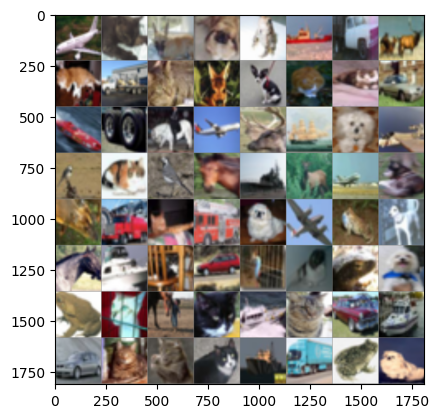

plane   cat   dog   dog


In [13]:
# function to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# ResNet Implementation

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import copy
import gc

alexnet = models.alexnet(weights=None)

# alexnet.eval()

# Prevent weight update from backprop
for param in alexnet.parameters():
    param.requires_grad = False

# Change the output layer to 10 classes
in_features = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(in_features, num_classes)

for param in alexnet.parameters():
    if param.requires_grad:
        print(param.shape)


torch.Size([10, 4096])
torch.Size([10])


## Train the model

In [15]:
batch_size = 64

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return correct / total

alexnet = alexnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(alexnet.parameters(), lr=0.1)

In [16]:
# Assuming other code is already in place
max_epochs = 20
n_iters = np.ceil(50000 / batch_size)
min_loss = 1000

loss_epoch_arr = []
train_loss_arr = []
val_loss_arr = []
train_acc_arr = []
val_acc_arr = []

for epoch in range(max_epochs):
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()
        outputs = alexnet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()

        train_loss += loss.item()  # Accumulate training loss

        # Update minimum loss and save best model
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(alexnet.state_dict())

        # Print training progress every 100 iterations
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %.2f' % (i, n_iters, loss.item()))

        # Clear memory
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

    # Record average training loss for the epoch
    train_loss_arr.append(train_loss / len(trainloader))

    # Validation loop to calculate validation loss
    alexnet.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = alexnet(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss_arr.append(val_loss / len(valloader))
    val_acc = correct / total
    val_acc_arr.append(val_acc)

    print(f'Epoch {epoch+1}/{max_epochs}, Train Loss: {train_loss_arr[-1]:.4f}, '
          f'Val Loss: {val_loss_arr[-1]:.4f}, Val Acc: {val_acc:.4f}')
    
    # Append final loss of epoch for historical tracking
    loss_epoch_arr.append(train_loss_arr[-1])

    # Switch back to training mode
    alexnet.train()


Iteration: 0/782, Loss: 2.30
Iteration: 100/782, Loss: 2.31


KeyboardInterrupt: 

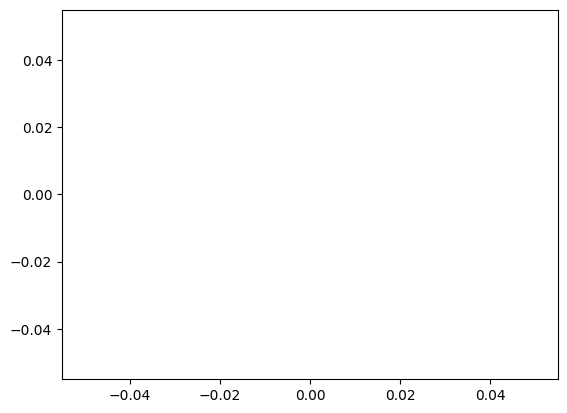

In [9]:
plt.plot(loss_epoch_arr)
plt.show()

In [10]:
alexnet.load_state_dict(best_model)
print(evaluation(trainloader, alexnet), evaluation(testloader, alexnet))

0.16493333333333332 0.1715


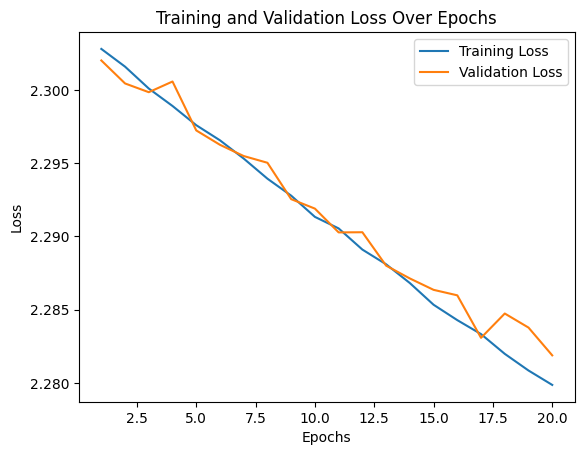

In [11]:
# Plot loss curves
plt.plot(range(1, max_epochs+1), train_loss_arr, label='Training Loss')
plt.plot(range(1, max_epochs+1), val_loss_arr, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

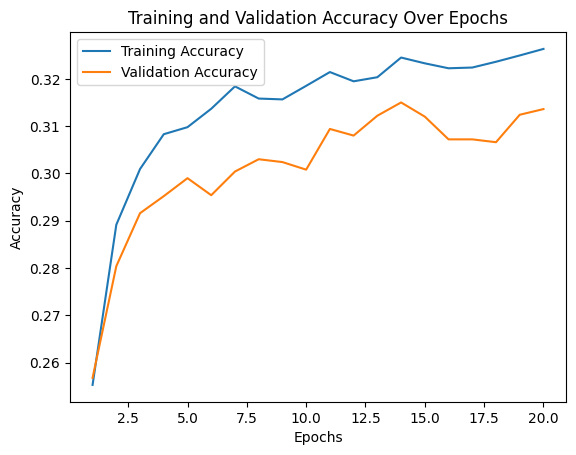

In [14]:
# Plot accuracy curves
plt.plot(range(1, max_epochs+1), train_acc_arr, label='Training Accuracy')
plt.plot(range(1, max_epochs+1), val_acc_arr, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy Over Epochs')
plt.show()


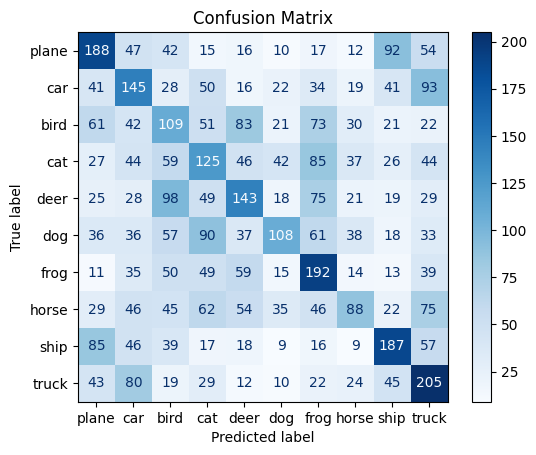

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate predictions on validation set
all_preds = []
all_labels = []
with torch.no_grad():
    for data in valloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

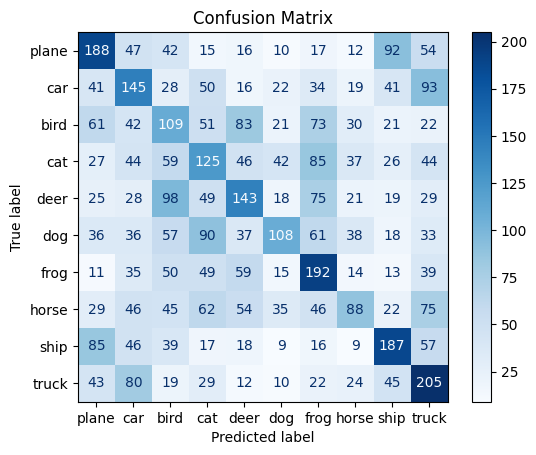

In [17]:
# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()